<a href="https://colab.research.google.com/github/AnasGamal/quantum-machine-learning-acmse-2025/blob/main/M1_Pennylane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary packages
!pip install pennylane
!pip install scikit-learn matplotlib numpy pandas
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pennylane as qml  # Quantum machine learning library
from pennylane import numpy as pnp  # NumPy optimized for PennyLane
from sklearn.model_selection import train_test_split  # Data splitting
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # Data normalization
from sklearn.svm import SVC  # Support Vector Classification
from sklearn.metrics import accuracy_score  # Model evaluation
import matplotlib.pyplot as plt  # Plotting
import numpy as np  # Numerical computing
import pandas as pd  # Data manipulation
from tqdm import tqdm  # Progress bar
import os  # File and directory operations

In [ ]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
data_read_path = os.path.join("drive", "MyDrive", "Colab Notebooks", "Datasets", "Base.csv")
df = pd.read_csv(data_read_path).dropna()

Mounted at /content/drive


In [ ]:
# Preprocessing the dataset
columns_to_drop = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
df.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')  # Remove specified columns

# Standardize all the features:
x = StandardScaler().fit_transform(np.array(df.drop(columns=['fraud_bool'], inplace=False)))  # Standardize features excluding target

# PCA fitting and transforming the data:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # Initialize PCA with 2 components
pca.fit(x)  # Fit PCA to the data
x = pca.transform(x)  # Transform data to 2 principal components

# Normalize the output to the range (-1, +1):
minmax_scale = MinMaxScaler((-1, 1)).fit(x)  # Initialize and fit MinMaxScaler
x = minmax_scale.transform(x).astype('float64')  # Apply scaling and convert to float64

# Convert the target column to numerical codes
y = np.array(df['fraud_bool'].astype('category').cat.codes.astype('float64'))  # Encode target as numerical values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.001, test_size=0.001, random_state=0)  # Split data with very small train and test sets

# Classical Machine Learning Model

In [ ]:
# Train a classical SVM model
classifier = SVC(kernel='linear', random_state=0)
classifier.fit(X_train, y_train)

# Evaluate the classical SVM model
y_pred_classical = classifier.predict(X_test)
Accuracy_Classical = accuracy_score(y_test, y_pred_classical)
print("Classical SVM accuracy:", Accuracy_Classical)

Classical SVM accuracy: 0.99


# Quantum SVM Implementation with PennyLane

In [ ]:
# Define the quantum device
n_qubits = 2  # Number of qubits to use
dev = qml.device("default.qubit", wires=n_qubits)  # Initialize a quantum device with 2 qubits

# Define the quantum circuit with a feature map (different gates are used to implement feature mapping)
def feature_map(x):
    # Apply Hadamard gates to create superposition
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.RY(x[i], wires=i)  # Encode feature values using RY rotation

    # Apply entangling operations
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])  # Entangle adjacent qubits
        qml.RZ(np.pi / 4, wires=i + 1)  # Apply phase rotation
        qml.CNOT(wires=[i, i + 1])  # Reverse entanglement

In [ ]:
# Define the quantum kernel
@qml.qnode(dev)
def quantum_kernel(x1, x2):
    feature_map(x1)  # Apply feature map to first input
    qml.adjoint(feature_map)(x2)  # Apply adjoint of feature map to second input
    return qml.expval(qml.PauliZ(0))  # Measure expectation value of PauliZ on first qubit

# Function to compute the kernel matrix with progress bar
def compute_kernel_matrix(data1, data2, desc="Kernel Matrix"):
    kernel_matrix = np.zeros((len(data1), len(data2)))  # Initialize kernel matrix
    for i, x1 in enumerate(tqdm(data1, desc=desc)):  # Iterate over first dataset with progress bar
        for j, x2 in enumerate(data2):  # Iterate over second dataset
            kernel_matrix[i, j] = quantum_kernel(x1, x2)  # Compute kernel value
    return kernel_matrix

# Compute kernel matrices for QSVM with progress bars
print("Computing training kernel matrix...")
kernel_matrix_train = compute_kernel_matrix(X_train, X_train, desc="Training Kernel Matrix")

print("Computing testing kernel matrix...")
kernel_matrix_test = compute_kernel_matrix(X_test, X_train, desc="Testing Kernel Matrix")

Computing training kernel matrix...


Training Kernel Matrix: 100%|██████████| 1000/1000 [1:20:01<00:00,  4.80s/it]


Computing testing kernel matrix...


Testing Kernel Matrix:  51%|█████     | 511/1000 [39:58<40:40,  4.99s/it]

In [ ]:
# Train the QSVM model using the quantum kernel
qsvm_classifier = SVC(kernel='precomputed')  # Initialize SVM classifier with precomputed kernel
qsvm_classifier.fit(kernel_matrix_train, y_train)  # Train the classifier using the quantum kernel matrix

# Predict using the QSVM model
y_pred_qsvm = qsvm_classifier.predict(kernel_matrix_test)  # Make predictions on test data

# Evaluate the QSVM model
Accuracy_Quantum = accuracy_score(y_test, y_pred_qsvm)  # Calculate accuracy of QSVM
print("Quantum QSVM accuracy:", Accuracy_Quantum)  # Print the accuracy

Quantum QSVM accuracy: 0.99


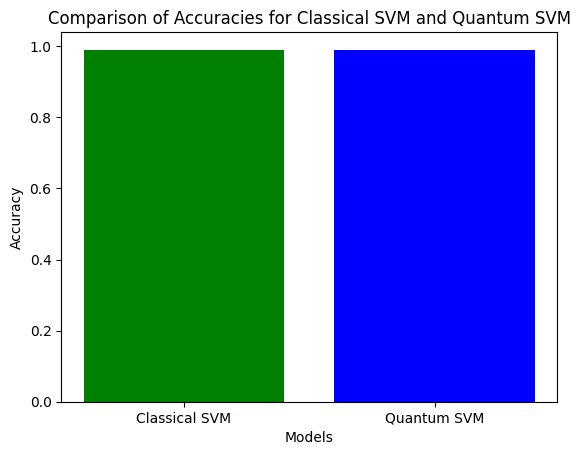

In [ ]:
# Plot the comparison of accuracies
models = ['Classical SVM', 'Quantum SVM']  # Labels for the models
accuracies = [Accuracy_Classical, Accuracy_Quantum]  # Accuracies of the models

# Create a bar plot
plt.bar(models, accuracies, color=['green', 'blue'])  # Plot bars with specified colors

# Add title and labels
plt.title('Comparison of Accuracies for Classical SVM and Quantum SVM')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Display the plot
plt.show()